# Depth Prediction Example with Monodepth2

### Set up path to enable importing certain packages

In [1]:
import sys
import os
cwd = os.getcwd()
wd = os.path.join(cwd, "monodepth2")
sys.path.append(wd)

### Import necessary packages

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader

from dataset import DepthEstDataset
from networks import ResnetEncoder, DepthDecoder
from layers import disp_to_depth

In [3]:
model_name = "monodepth2"
# to cap depth between 0.001 and 10
min_depth = 0.001
max_depth = 10

if torch.cuda.is_available:
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

### Load model from checkpoint

In [4]:
# checkpoint paths
checkpt_name = "mono_640x192"
checkpt_path = os.path.join(model_name, "checkpts", checkpt_name)
encoder_path = os.path.join(checkpt_path, "encoder.pth")
decoder_path = os.path.join(checkpt_path, "depth.pth")

In [5]:
# load encoder
encoder = ResnetEncoder(18, False)
loaded_dict_enc = torch.load(encoder_path, map_location=device)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)
encoder.to(device)
encoder.eval()
print("Loaded pretrained encoder")

Loaded pretrained encoder


In [6]:
# Load decoder
depth_decoder = DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
loaded_dict_dec = torch.load(decoder_path, map_location=device)
filtered_dict_dec = {k: v for k, v in loaded_dict_dec.items() if k in depth_decoder.state_dict()}
depth_decoder.load_state_dict(filtered_dict_dec)
depth_decoder.to(device)
depth_decoder.eval()
print("Loaded pretrained decoder")

Loaded pretrained decoder


The pretrained model uses images with large aspect ratio. Need to extract the image size that the model was pretrained with. The test images need to be resized to the pretrained image size first before prediction

In [7]:
feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']

### Predict depth from input images

In [8]:
depth_dataset = DepthEstDataset(model_name)
test_loader = DataLoader(depth_dataset, batch_size=1, shuffle=True)

In [9]:
with torch.no_grad():
    for batch_id, inputs in enumerate(test_loader):
        # the dataset can be used for both monocular and stereo models
        # only left image is needed for monocular model
        left_im, _, pred_depth_path = inputs
        left_im = left_im.to(device)
        _, _, original_height, original_width = list(left_im.shape)
        left_im = F.interpolate(left_im, (feed_height, feed_width), mode='bilinear', align_corners=False)
        
        features = encoder(left_im)
        outputs = depth_decoder(features)
        disp = outputs[("disp", 0)]  # technically the model outputs inverse depth
        disp = F.interpolate(disp, (original_height, original_width), mode='bilinear', align_corners=False)
        _, depth = disp_to_depth(disp, min_depth, max_depth)
        depth = depth.detach().cpu().numpy()
        depth = np.squeeze(depth)
        # Note the depth needs to be scaled with median from ground truth prior to computing the error metrics.
        # This is a common practice in unsupervised monocular models since the models have no knowledge of the
        # depth scale
        np.save(pred_depth_path[0], depth)

### Print a sample image and its predicted depth

In [10]:
left_im = F.interpolate(left_im, (original_height, original_width), mode='bilinear', align_corners=False)
left_im = torch.squeeze(left_im)
left_im = left_im.detach().cpu()
left_im = transforms.ToPILImage()(left_im)

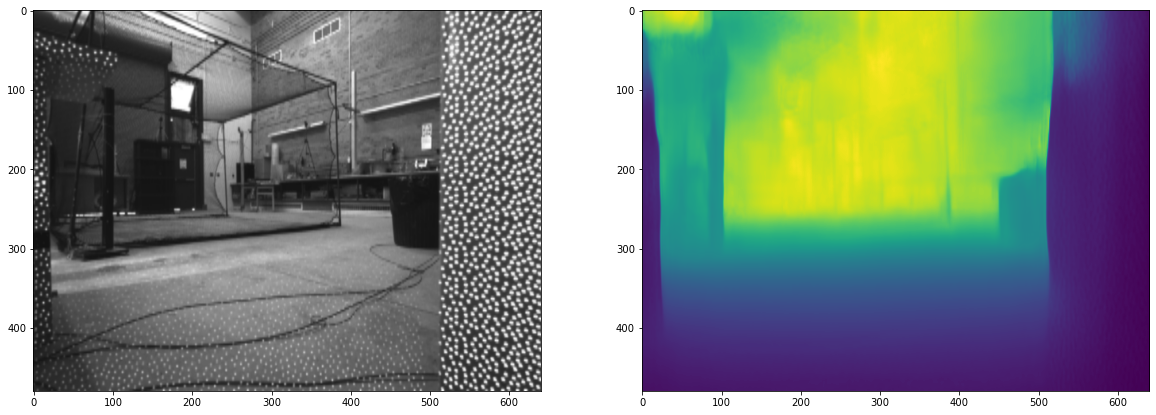

In [11]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(left_im)
plt.subplot(122)
plt.imshow(depth)

In [12]:
print(np.amin(depth))  # definitely need to scale depth using median from ground truth
print(np.amax(depth))

0.0013346354
0.008138399
